# Note

1. HVAC States data has duplicate points! "df.loc[start] start=pd.Timestamp('2018-08-01')"
1. Can't normalize data if it's not stationary.

In [27]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_folder = 'data'
site = 'avenal-movie-theatre'

# Import data

## Eagle (power) data

In [3]:
df_raw = pd.read_csv(data_folder + '/power_' + site + '.csv', index_col=[0], parse_dates=True)
df_raw = df_raw[(df_raw.index < '2019-04-01')]
df_raw.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/tools/datetimes.py:314: UserWarning: Discarding nonzero nanoseconds in conversion
  for ts in result]


,power
datetime,
2018-01-01 00:00:04.574889+00:00,400.0
2018-01-01 00:00:10.215095+00:00,440.0
2018-01-01 00:00:13.496753+00:00,440.0
2018-01-01 00:00:20.031088+00:00,440.0
2018-01-01 00:00:33.525473+00:00,400.0


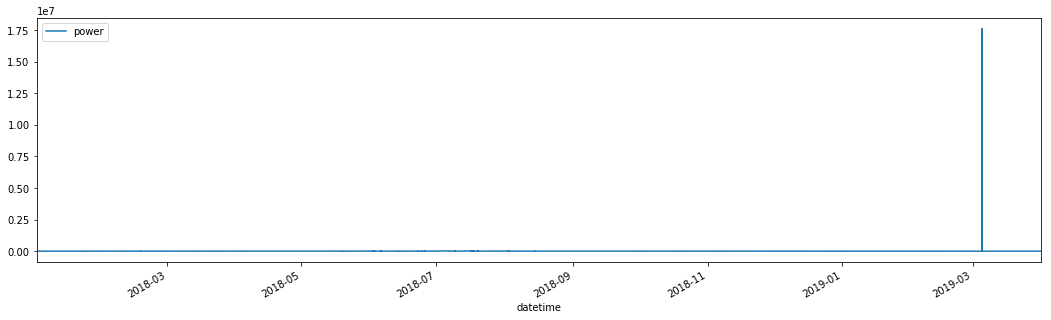

In [28]:
df_raw.plot(figsize=(18,5))

### Check for missing data

In [5]:
df_raw.isna().any()

power    False
dtype: bool

### Clean data

In [8]:
df_processed = df_raw.resample('15T').mean()
df_processed = df_processed[df_processed['power'] < 10000000]
df_processed = df_processed[(np.abs(stats.zscore(df_processed)) < float(3)).all(axis=1)]
df_processed.dropna(inplace=True)
df_processed.head()

,power
datetime,
2018-01-01 00:00:00+00:00,416.991150
2018-01-01 00:15:00+00:00,477.477477
2018-01-01 00:30:00+00:00,430.990991
2018-01-01 00:45:00+00:00,504.081633
2018-01-01 01:00:00+00:00,453.565217


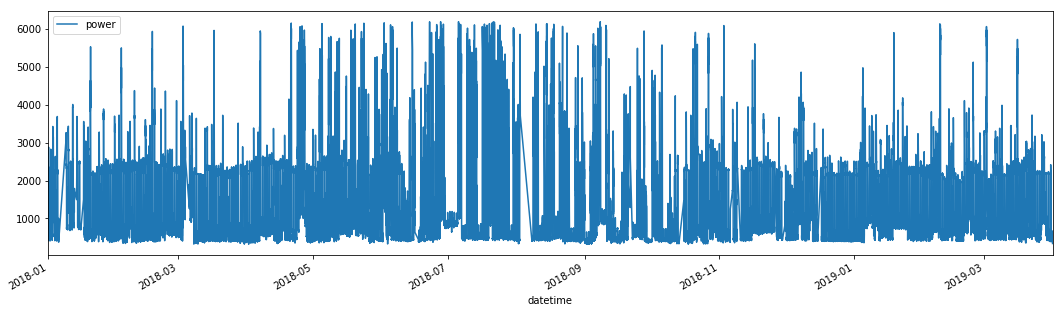

In [29]:
df_processed.plot(figsize=(18,5))

### Check for stationarity

Null hypothesis is that the data is non-stationary. Since p-value > critical value --> data is non-stationary.

In [14]:
result = adfuller(df_processed['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistic            -30.665127
p-value                     0.000000
#Lags Used                 48.000000
#Observations Used      40294.000000
Critical Value (1%)        -3.430512
Critical Value (5%)        -2.861612
Critical Value (10%)       -2.566808
dtype: float64

### Make data stationary

Since p-value < critical value --> data is stationary

In [19]:
df_stationary = df_processed.diff(1).dropna()

result = adfuller(df_stationary['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistic            -42.270404
p-value                     0.000000
#Lags Used                 54.000000
#Observations Used      40287.000000
Critical Value (1%)        -3.430512
Critical Value (5%)        -2.861612
Critical Value (10%)       -2.566808
dtype: float64

### Normalize data

In [25]:
scaler = MinMaxScaler(feature_range=(0,1))
df_normalized = pd.DataFrame(scaler.fit_transform(df_stationary), 
                             columns=df_stationary.columns, index=df_stationary.index)
df_normalized.head()

,power
datetime,
2018-01-01 00:15:00+00:00,0.457473
2018-01-01 00:30:00+00:00,0.446950
2018-01-01 00:45:00+00:00,0.458712
2018-01-01 01:00:00+00:00,0.446554
2018-01-01 01:15:00+00:00,0.452347


## HVAC States data

In [57]:
df_raw_hvac_states = pd.read_csv(data_folder + '/hvac_states_' + site + '.csv', index_col=[0], parse_dates=True)
df_raw_hvac_states.head()

,hvac_zone_lobby,hvac_zone_main_hallway,hvac_zone_room_a,hvac_zone_theater_2,hvac_zone_back_hallway,hvac_zone_room_d,hvac_zone_pegasus_hall,hvac_zone_theater_1
2018-01-01 00:00:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:05:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:10:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:15:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:20:00+00:00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Check for missing data

In [58]:
missing = df_raw_hvac_states.isnull().sum()
total = df_raw_hvac_states.shape[0]
print('missing data for power: \n', (missing/total)*100)

missing data for power: 
 hvac_zone_lobby           6.264120
hvac_zone_main_hallway    4.201056
hvac_zone_room_a          3.898381
hvac_zone_theater_2       4.708749
hvac_zone_back_hallway    3.973948
hvac_zone_room_d          4.026830
hvac_zone_pegasus_hall    4.581074
hvac_zone_theater_1       5.845112
dtype: float64


In [83]:
def func(row):
    """ Possible situations: (0,0,0), (1,0,1), (0,1,2) --> 0, 1, 2
    
    If all are same --> first element
    If there is a majority among the 3 --> majority
    If all are unique --> last element
    
    """

    count = len(set(list(row.values)))
    if count == 1:
        return row.values[0]
    elif count == 2:
        return max(set(list(row.values)), key=list(row.values).count)
    else:
        return row.values[-1]
    
resample_df_hvac = df_raw_hvac_states.resample('15T').apply(func).dropna()

In [87]:
missing = resample_df_hvac.isnull().sum()
total = resample_df_hvac.shape[0]
print('missing data for power: \n', (missing/total)*100)

missing data for power: 
 hvac_zone_lobby           0.0
hvac_zone_main_hallway    0.0
hvac_zone_room_a          0.0
hvac_zone_theater_2       0.0
hvac_zone_back_hallway    0.0
hvac_zone_room_d          0.0
hvac_zone_pegasus_hall    0.0
hvac_zone_theater_1       0.0
dtype: float64
